# Notebook 13 d) Multi-class Sentiment Model Using Neural Networks

This notebook seeks to train a MULTI-CLASS model to predict sentiment on the full dataset based only on the noun phrases previously extracted but using neural network models instead of machine learning.

* Section 1 - Import libraries and data
* Section 2 - Data preprocessing
* Section 3 - Building a sentiment model (Models 1 to 5 based on the best simple networks from Notebook 8)
* Section 4 - Summary results table

NOTE: Cross validation could not be run on this dataset as it is too resource-intensive. Only a hold-out set is used for evaluation.

Datasets need to run file:
* combined_sentiment.csv
* combined_sentiment_test.csv

Models saved to:
* SentimentModels1
* SentimentModels2
* SentimentModels3
* SentimentModels4
* SentimentModels5

Final results:

* results_sentiment.csv


# Section 1: Import libraries and data

In [355]:
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import StratifiedKFold
import keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense,Flatten,Embedding,LSTM,Dropout,SpatialDropout1D,Conv1D,GlobalMaxPooling1D,SimpleRNN,LSTM,GRU,Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.utils import to_categorical
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
import os
import pickle

import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score,recall_score,f1_score,confusion_matrix,classification_report
from sklearn.utils import class_weight

import warnings
warnings.filterwarnings('ignore')

In [356]:
# Bring in training and test sets from Notebook 11 (visualising topic models)
df_train = pd.read_csv("combined_sentiment.csv",index_col = 0)
df_test = pd.read_csv("combined_sentiment_test.csv",index_col = 0)

In [357]:
# Combine train and test set
df_combined_all = pd.concat([df_train, df_test],axis = 0,ignore_index = True)
df_combined_all.shape

(73027, 15)

# Section 2: Data preprocessing

In [358]:
# Choose columns, replace incorrect category label and relabel columns
df_train = df_train[["OrigInd","Category","noun_phrases","Topic Count","Sentiment","Score"]]
df_train.columns = ["OrigInd","Category","Noun Phrases","Aspect","Sentiment","Polarity"]
df_test = df_test[["OrigInd","Category","noun_phrases","Topic","Sentiment","Score"]]
df_test["Category"].replace({"Attract": "Attractions"}, inplace=True)
df_test.columns = ["OrigInd","Category","Noun Phrases","Aspect","Sentiment","Polarity"]

In [359]:
# Get Category distribution
df_combined_all["Category"].value_counts()

Food             40587
Accommodation    24670
Attractions       7560
Attract            210
Name: Category, dtype: int64

In [360]:
df_combined_all.head(2)

,Unnamed: 0.1,OrigInd,Category,Town,Rating,all_text,cleaned,noun_phrases,nouns,Topic Count,Topic TFIDF,Sentiment,Score,Sentence,Topic
0,0,0,Accommodation,Bognor,4,"Nice break, shame about the accommodation... W...",nice break shame accommodation booked night st...,shame accommodation,"['shame', 'accommodation']",VFM,VisitExp,-0.4767,negative,NaN,NaN
1,1,0,Accommodation,Bognor,4,"Nice break, shame about the accommodation... W...",nice break shame accommodation booked night st...,night stay december post-christmas,"['night', 'post-christmas']",Hotel Location,Restaurant,0.0000,neutral,NaN,NaN


In [361]:
# Get Polarity distribution
df_combined_all["Score"].value_counts()

neutral     39099
positive    29513
negative     4415
Name: Score, dtype: int64

<BarContainer object of 3 artists>

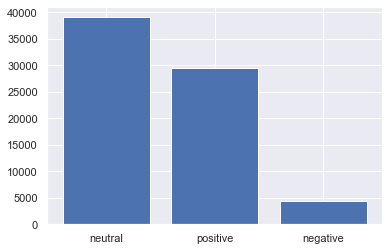

In [362]:
# Distribution of polarities
sent = pd.DataFrame(df_combined_all["Score"].value_counts())
plt.bar(sent.index,sent["Score"])

In [363]:
df_combined_all["Score"].replace({"positive": 1,"negative":-1,"neutral":0}, inplace=True)
df_combined_all["Score"].value_counts()

 0    39099
 1    29513
-1     4415
Name: Score, dtype: int64

In [364]:
pos_sampled = df_combined_all[df_combined_all["Score"] == 1].sample(4415)
neutral_sampled = df_combined_all[df_combined_all["Score"] == 0].sample(4415)
negative = df_combined_all[df_combined_all["Score"] == -1]
print(pos_sampled.shape, neutral_sampled.shape,negative.shape)

(4415, 15) (4415, 15) (4415, 15)


In [365]:
df_combined_all = pd.concat([pos_sampled, neutral_sampled,negative], axis = 0, ignore_index = True)
df_combined_all.shape

(13245, 15)

<BarContainer object of 3 artists>

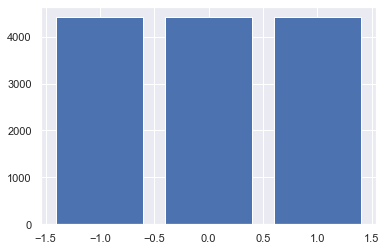

In [366]:
# Distribution of polarities
sent = pd.DataFrame(df_combined_all["Score"].value_counts())
plt.bar(sent.index,sent["Score"])

## Define X and y and split into training, valuation and test sets

In [367]:
X = df_combined_all["noun_phrases"]
y = df_combined_all["Score"]

In [368]:
# Train, validation, test split
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y,test_size=0.2, shuffle = True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, stratify = y_test,test_size=0.50, shuffle = True) 

In [369]:
print(X_train.shape,X_val.shape,X_test.shape,y_train.shape,y_val.shape,y_test.shape)

(10596,) (1325,) (1324,) (10596,) (1325,) (1324,)


In [370]:
y_train.value_counts()

 0    3532
 1    3532
-1    3532
Name: Score, dtype: int64

In [371]:
y_val.value_counts()

-1    442
 0    442
 1    441
Name: Score, dtype: int64

In [372]:
y_test.value_counts()

 1    442
-1    441
 0    441
Name: Score, dtype: int64

## Distribution of noun phrases

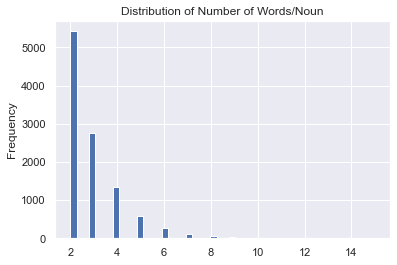

In [373]:
pd.DataFrame(X_train)["noun_phrases"].str.split().apply(len).plot.hist(bins = 50, title = "Distribution of Number of Words/Noun")
plt.show()

In [374]:
pd.DataFrame(X_train)["noun_phrases"].str.split().apply(len).max()

15

## Encoding X values

In [375]:
def tok(X_train, X_val, X_test):
    tokenizer = Tokenizer(num_words = 5000)
    tokenizer.fit_on_texts(X_train)
    X_train_s = tokenizer.texts_to_sequences(X_train)
    X_val_s = tokenizer.texts_to_sequences(X_val)
    X_test_s = tokenizer.texts_to_sequences(X_test)
    X_train_w = pad_sequences(np.array(X_train_s,dtype = "object"), maxlen=20, padding="post", truncating="post", value=0.0)
    X_val_w = pad_sequences(np.array(X_val_s,dtype = "object"), maxlen=20, padding="post", truncating="post", value=0.0)
    X_test_w = pad_sequences(np.array(X_test_s, dtype = "object"), maxlen = 20, padding = "post", truncating = "post", value = 0.0)
    
    return tokenizer, X_train_w, X_val_w, X_test_w

In [376]:
# Apply function to X training, validation and test sets
tok,X_train_w, X_val_w, X_test_w = tok(X_train, X_val, X_test)

In [377]:
# Save tokenizer objects for use in the combined final model
def tok_save(name,tokenizer):
    with open(name, 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
# Save tokenizer pickle files
tok_save('tok_sent_multiclass.pickle',tok)

In [378]:
# Encode as one hot encoding for network
def bin(y_train, y_val, y_test):
    binarizer = preprocessing.LabelBinarizer()
    y_train_e = binarizer.fit_transform(y_train)
    y_val_e = binarizer.transform(y_val)
    y_test_e = binarizer.transform(y_test)
    return y_train_e,y_val_e,y_test_e

In [379]:
# Function to encode y values as integer labels (necessary for stratified cross validation as one-hot encoded doesn't work)
def lab(y_train, y_val, y_test):
    le = preprocessing.LabelEncoder()
    y_train_l = le.fit_transform(y_train)
    y_val_l = le.fit_transform(y_val)
    y_test_l = le.transform(y_test)
    return y_train_l,y_val_l, y_test_l

In [380]:
y_train_e, y_val_e, y_test_e = bin(y_train, y_val, y_test)
y_train_l, y_val_l, y_test_l = lab(y_train, y_val, y_test)

In [381]:
print(y_train_e.shape, y_val_e.shape, y_test_e.shape)
print(y_train_l.shape, y_val_l.shape, y_test_l.shape)

(10596, 3) (1325, 3) (1324, 3)
(10596,) (1325,) (1324,)


In [382]:
pd.DataFrame(y_val).value_counts()

Score
-1       442
 0       442
 1       441
dtype: int64

# Section 3: Building a Sentiment Model

## Setting Functions

In [383]:
# Visualise the training and test accuracies and losses

import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Val acc')
    plt.title('Training and Validation accuracy')
    plt.xlabel("Epochs")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Val loss')
    plt.xlabel("Epochs")
    plt.title('Training and Validation loss')
    plt.legend()
    plt.show()

In [384]:
# The model will use earlystopping if the valuation loss doesn't decrease after a specified number of epochs

def out(name):
    output_dir = name
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    return output_dir
        
def call(output_dir,patience):
    modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
    callbacks = [EarlyStopping(monitor = "val_loss", patience = patience),modelcheckpoint]
    return callbacks

In [385]:
# Confusion Matrix function

def class_conf(y_val_integer,y_pred_class,labels):
    classification = classification_report(y_val_integer, y_pred_class)
    cf_matrix = confusion_matrix(y_val_integer, y_pred_class)
    fig, ax = plt.subplots(figsize = (8,6))
    sns.heatmap(cf_matrix, annot = True, fmt = "d",cmap = plt.cm.Blues,xticklabels = labels,yticklabels = labels)
    ax.set_xlabel('Predicted',labelpad = 10)
    ax.set_ylabel('Actual',labelpad = 10)
    plt.title("Confusion Matrix", fontsize = 15)
    print(classification)
    plt.show()

In [386]:
# Evaluation function

def eval(model,output_dir,name,X_val,y_val_e,y_val,labels):
    model.load_weights(output_dir+name)
    y_pred_prob = model.predict(X_val)
    y_pred_class = np.argmax(model.predict(X_val), axis=-1)
    y_val_integer = np.argmax(y_val, axis=1)
    df_pred = pd.DataFrame(list(zip(y_val_integer, y_val,y_pred_class)), columns=["Actual Class", "Actual Aspect","Predicted Class",])
    df_wrong = df_pred[df_pred["Actual Class"]!= df_pred["Predicted Class"]]
    class_conf(y_val_integer,y_pred_class,labels)
    print("\n")
    print("The model predicted:", df_wrong.shape[0],"aspects wrong from a total of:",df_pred.shape[0],"predictions")
    print("\n")
    return df_pred, df_wrong

In [387]:
# Metrics function

def metric_results(y_val_e,y_val_integer,y_pred_class,y_pred_prob):
    accuracy = accuracy_score(y_val_integer, y_pred_class)
    rocauc = roc_auc_score(y_val_e,y_pred_prob, average = 'macro', multi_class = 'ovr')
    precision = precision_score(y_val_integer, y_pred_class, average='macro')
    recall = recall_score(y_val_integer, y_pred_class, average='macro')
    f1 = f1_score(y_val_integer, y_pred_class, average='macro')
          
    
    results = pd.DataFrame({"Accuracy":accuracy, "Precision":precision, "Recall":recall,
                                    "F1":f1,"ROCAUC":rocauc}, index = [0]
                                  )
    return results

In [388]:
# Balanced classes - get weights
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
class_weights

array([1., 1., 1.])

## Sentiment Model 1

In [399]:
# Parameters
input_dim = 6000
output_dim = 16
input_length = 20
batch_size = 8
epochs = 50
class_weights = {0:0.62257958,1:0.82480587,2:5.51349566}

# Set output directory and callbacks (patience set to 5)
output_dir = out('model_output/SentimentMultiClass1')
callbacks = call(output_dir,5)

In [400]:
model1 = Sequential()
model1.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length=input_length))
model1.add(Flatten())
model1.add(Dense(3, activation='softmax'))
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model1.summary()) 
 

Model: "sequential_165"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_165 (Embedding)    (None, 20, 16)            96000     
_________________________________________________________________
flatten_165 (Flatten)        (None, 320)               0         
_________________________________________________________________
dense_487 (Dense)            (None, 3)                 963       
Total params: 96,963
Trainable params: 96,963
Non-trainable params: 0
_________________________________________________________________
None


In [401]:
# Model using keras embeddings
history = model1.fit(X_train_w,y_train_e,
                    epochs=epochs,
                    verbose=2,
                    callbacks = callbacks,
                    validation_data=(X_val_w, y_val_e),
                    batch_size=batch_size)

Epoch 1/50
1325/1325 - 1s - loss: 0.6970 - accuracy: 0.7497 - val_loss: 0.3910 - val_accuracy: 0.8755
Epoch 2/50
1325/1325 - 1s - loss: 0.2453 - accuracy: 0.9314 - val_loss: 0.2289 - val_accuracy: 0.9298
Epoch 3/50
1325/1325 - 1s - loss: 0.1131 - accuracy: 0.9731 - val_loss: 0.1855 - val_accuracy: 0.9381
Epoch 4/50
1325/1325 - 1s - loss: 0.0591 - accuracy: 0.9883 - val_loss: 0.1740 - val_accuracy: 0.9464
Epoch 5/50
1325/1325 - 1s - loss: 0.0328 - accuracy: 0.9954 - val_loss: 0.1668 - val_accuracy: 0.9517
Epoch 6/50
1325/1325 - 1s - loss: 0.0193 - accuracy: 0.9975 - val_loss: 0.1589 - val_accuracy: 0.9517
Epoch 7/50
1325/1325 - 1s - loss: 0.0120 - accuracy: 0.9991 - val_loss: 0.1688 - val_accuracy: 0.9509
Epoch 8/50
1325/1325 - 1s - loss: 0.0080 - accuracy: 0.9992 - val_loss: 0.1652 - val_accuracy: 0.9532
Epoch 9/50
1325/1325 - 1s - loss: 0.0056 - accuracy: 0.9994 - val_loss: 0.1710 - val_accuracy: 0.9532
Epoch 10/50
1325/1325 - 1s - loss: 0.0039 - accuracy: 0.9996 - val_loss: 0.1779 - 

In [402]:
# Print training and test accuracies
loss, accuracy = model1.evaluate(X_train_w, y_train_e, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model1.evaluate(X_val_w, y_val_e, verbose=False)
print("Validation Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9997
Validation Accuracy:  0.9555


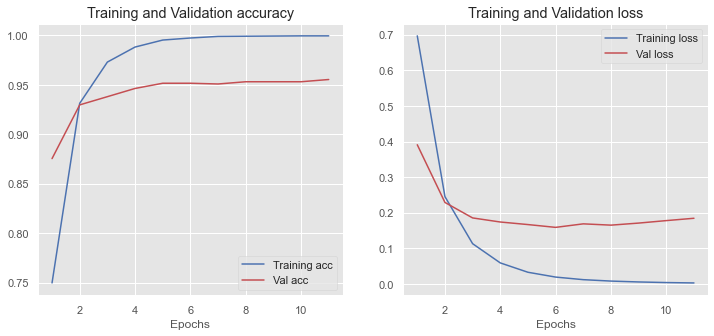

In [403]:
plot_history(history)

In [405]:
# Load model weights from epoch with best validation accuracy
model1.load_weights(output_dir+"/weights.11.hdf5")

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       442
           1       0.91      0.98      0.94       442
           2       0.99      0.95      0.97       441

    accuracy                           0.96      1325
   macro avg       0.96      0.96      0.96      1325
weighted avg       0.96      0.96      0.96      1325



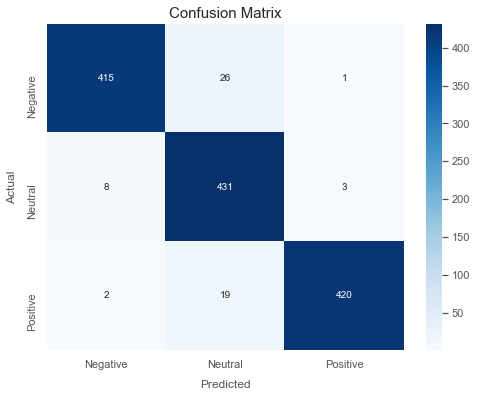

In [406]:
labels = ['Negative','Neutral','Positive']
y_pred_prob = model1.predict(X_val_w)
y_pred_class = np.argmax(model1.predict(X_val_w), axis=-1)
y_val_integer = np.argmax(y_val_e, axis=1)
class_conf(y_val_integer,y_pred_class,labels)

In [407]:
results1 = metric_results(y_val_e,y_val_integer,y_pred_class,y_pred_prob)
results1

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.955472,0.9575,0.955469,0.955807,0.991916


## Sentiment Model 2

In [408]:
model2 = Sequential()
model2.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length=input_length))
model2.add(Flatten())
model2.add(Dense(64, activation='relu', input_shape=(1600,)))
model2.add(Dense(3, activation='softmax'))
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model2.summary())

Model: "sequential_166"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_166 (Embedding)    (None, 20, 16)            96000     
_________________________________________________________________
flatten_166 (Flatten)        (None, 320)               0         
_________________________________________________________________
dense_488 (Dense)            (None, 64)                20544     
_________________________________________________________________
dense_489 (Dense)            (None, 3)                 195       
Total params: 116,739
Trainable params: 116,739
Non-trainable params: 0
_________________________________________________________________
None


In [409]:
model2.save('bestsentimentnetworkmodel.h5')

In [410]:
# Set output directory and callbacks (patience set to 5)
output_dir = out('model_output/SentimentMultiClass2')
callbacks = call(output_dir,5)

In [411]:
# Model using keras embeddings
history = model2.fit(X_train_w,y_train_e,
                     epochs=epochs,
                     verbose=2,
                     callbacks = callbacks,
                     validation_data=(X_val_w, y_val_e),
                     batch_size=batch_size)
                

Epoch 1/50
1325/1325 - 1s - loss: 0.5037 - accuracy: 0.7895 - val_loss: 0.2306 - val_accuracy: 0.9223
Epoch 2/50
1325/1325 - 1s - loss: 0.1059 - accuracy: 0.9677 - val_loss: 0.1789 - val_accuracy: 0.9343
Epoch 3/50
1325/1325 - 1s - loss: 0.0262 - accuracy: 0.9946 - val_loss: 0.1779 - val_accuracy: 0.9426
Epoch 4/50
1325/1325 - 1s - loss: 0.0091 - accuracy: 0.9992 - val_loss: 0.1703 - val_accuracy: 0.9502
Epoch 5/50
1325/1325 - 1s - loss: 0.0050 - accuracy: 0.9995 - val_loss: 0.1918 - val_accuracy: 0.9540
Epoch 6/50
1325/1325 - 1s - loss: 0.0027 - accuracy: 0.9994 - val_loss: 0.2053 - val_accuracy: 0.9547
Epoch 7/50
1325/1325 - 1s - loss: 0.0025 - accuracy: 0.9991 - val_loss: 0.2123 - val_accuracy: 0.9532
Epoch 8/50
1325/1325 - 1s - loss: 5.4953e-04 - accuracy: 1.0000 - val_loss: 0.2086 - val_accuracy: 0.9555
Epoch 9/50
1325/1325 - 1s - loss: 4.6085e-04 - accuracy: 0.9999 - val_loss: 0.2326 - val_accuracy: 0.9562


In [412]:
# Print training and test accuracies
loss, accuracy = model2.evaluate(X_train_w, y_train_e, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model2.evaluate(X_val_w, y_val_e, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9999
Testing Accuracy:  0.9562


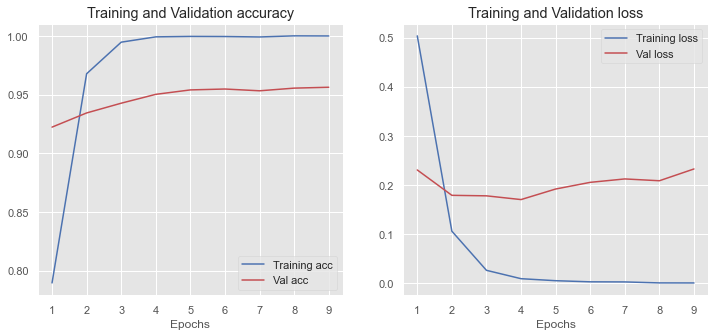

In [413]:
plot_history(history)

In [415]:
# Load model weights from epoch with best validation accuracy
model2.load_weights(output_dir+"/weights.09.hdf5")

              precision    recall  f1-score   support

           0       0.98      0.93      0.96       442
           1       0.91      0.98      0.94       442
           2       0.98      0.96      0.97       441

    accuracy                           0.96      1325
   macro avg       0.96      0.96      0.96      1325
weighted avg       0.96      0.96      0.96      1325



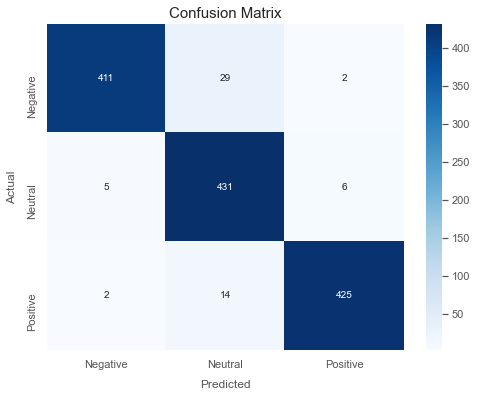

In [416]:
y_pred_prob = model2.predict(X_val_w)
y_pred_class = np.argmax(model2.predict(X_val_w), axis=-1)
y_val_integer = np.argmax(y_val_e, axis=1)
class_conf(y_val_integer,y_pred_class,labels)

In [417]:
results2 = metric_results(y_val_e,y_val_integer,y_pred_class,y_pred_prob)
results2

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.956226,0.95802,0.956232,0.956467,0.992249


## Sentiment Model 3

In [418]:
# Network with a hidden layer with more neurons in the dense layer and with dropout of 50%
model3 = Sequential()
model3.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length=input_length))
model3.add(Flatten())
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(rate=0.5))
model3.add(Dense(3, activation='softmax')) 
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model3.summary())


Model: "sequential_167"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_167 (Embedding)    (None, 20, 16)            96000     
_________________________________________________________________
flatten_167 (Flatten)        (None, 320)               0         
_________________________________________________________________
dense_490 (Dense)            (None, 128)               41088     
_________________________________________________________________
dropout_314 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_491 (Dense)            (None, 3)                 387       
Total params: 137,475
Trainable params: 137,475
Non-trainable params: 0
_________________________________________________________________
None


In [419]:
# Set output directory and callbacks (patience set to 5)
output_dir = out('model_output/SentimentMultiClass3')
callbacks = call(output_dir,5)

In [420]:
# Model using keras embeddings
history = model3.fit(X_train_w,y_train_e,
                     epochs=epochs,
                     verbose=2,
                     callbacks = callbacks,
                     validation_data=(X_val_w, y_val_e),
                     batch_size=batch_size)

Epoch 1/50
1325/1325 - 1s - loss: 0.5321 - accuracy: 0.7730 - val_loss: 0.2241 - val_accuracy: 0.9140
Epoch 2/50
1325/1325 - 1s - loss: 0.1265 - accuracy: 0.9639 - val_loss: 0.1586 - val_accuracy: 0.9540
Epoch 3/50
1325/1325 - 1s - loss: 0.0350 - accuracy: 0.9904 - val_loss: 0.1654 - val_accuracy: 0.9532
Epoch 4/50
1325/1325 - 1s - loss: 0.0121 - accuracy: 0.9979 - val_loss: 0.1719 - val_accuracy: 0.9623
Epoch 5/50
1325/1325 - 1s - loss: 0.0072 - accuracy: 0.9992 - val_loss: 0.2307 - val_accuracy: 0.9555
Epoch 6/50
1325/1325 - 1s - loss: 0.0039 - accuracy: 0.9994 - val_loss: 0.2481 - val_accuracy: 0.9547
Epoch 7/50
1325/1325 - 1s - loss: 0.0043 - accuracy: 0.9988 - val_loss: 0.2145 - val_accuracy: 0.9547


In [421]:
# Print training and test accuracies
loss, accuracy = model3.evaluate(X_train_w, y_train_e, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model3.evaluate(X_val_w, y_val_e, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9996
Testing Accuracy:  0.9547


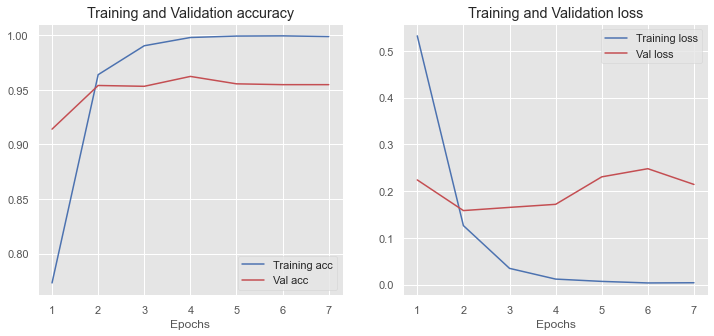

In [422]:
plot_history(history)

In [423]:
# Load model weights from epoch with best validation accuracy
model3.load_weights(output_dir+"/weights.04.hdf5")

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       442
           1       0.93      0.97      0.95       442
           2       0.99      0.96      0.98       441

    accuracy                           0.96      1325
   macro avg       0.96      0.96      0.96      1325
weighted avg       0.96      0.96      0.96      1325



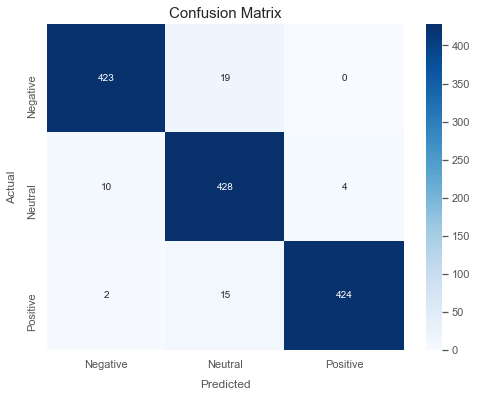

In [424]:
y_pred_prob = model3.predict(X_val_w)
y_pred_class = np.argmax(model3.predict(X_val_w), axis=-1)
y_val_integer = np.argmax(y_val_e, axis=1)
class_conf(y_val_integer,y_pred_class,labels)

In [425]:
results3 = metric_results(y_val_e,y_val_integer,y_pred_class,y_pred_prob)
results3

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.962264,0.963158,0.962264,0.962463,0.992342


## Sentiment Model 4

In [426]:
# Dense model with 2 hidden dense layers and dropout on each
model4 = Sequential()
model4.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length=input_length))
model4.add(Flatten())
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(rate=0.5))
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(rate = 0.5))
model4.add(Dense(3, activation='softmax')) 
model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model4.summary())

Model: "sequential_168"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_168 (Embedding)    (None, 20, 16)            96000     
_________________________________________________________________
flatten_168 (Flatten)        (None, 320)               0         
_________________________________________________________________
dense_492 (Dense)            (None, 128)               41088     
_________________________________________________________________
dropout_315 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_493 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_316 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_494 (Dense)            (None, 3)              

In [427]:
# Set output directory and callbacks (patience set to 5)
output_dir = out('model_output/SentimentMultiClass4')
callbacks = call(output_dir,5)

In [428]:
# Model using keras embeddings
history = model4.fit(X_train_w,y_train_e,
                     epochs=epochs,
                     verbose=2,
                     callbacks = callbacks,
                     validation_data=(X_val_w, y_val_e),
                     batch_size=batch_size)

Epoch 1/50
1325/1325 - 1s - loss: 0.5428 - accuracy: 0.7562 - val_loss: 0.2192 - val_accuracy: 0.9283
Epoch 2/50
1325/1325 - 1s - loss: 0.1358 - accuracy: 0.9572 - val_loss: 0.1767 - val_accuracy: 0.9464
Epoch 3/50
1325/1325 - 1s - loss: 0.0348 - accuracy: 0.9902 - val_loss: 0.1903 - val_accuracy: 0.9562
Epoch 4/50
1325/1325 - 1s - loss: 0.0159 - accuracy: 0.9961 - val_loss: 0.2330 - val_accuracy: 0.9562
Epoch 5/50
1325/1325 - 1s - loss: 0.0136 - accuracy: 0.9965 - val_loss: 0.2520 - val_accuracy: 0.9502
Epoch 6/50
1325/1325 - 1s - loss: 0.0112 - accuracy: 0.9975 - val_loss: 0.2274 - val_accuracy: 0.9577
Epoch 7/50
1325/1325 - 1s - loss: 0.0061 - accuracy: 0.9983 - val_loss: 0.3240 - val_accuracy: 0.9555


In [429]:
# Print training and test accuracies
loss, accuracy = model4.evaluate(X_train_w, y_train_e, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model4.evaluate(X_val_w, y_val_e, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9993
Testing Accuracy:  0.9555


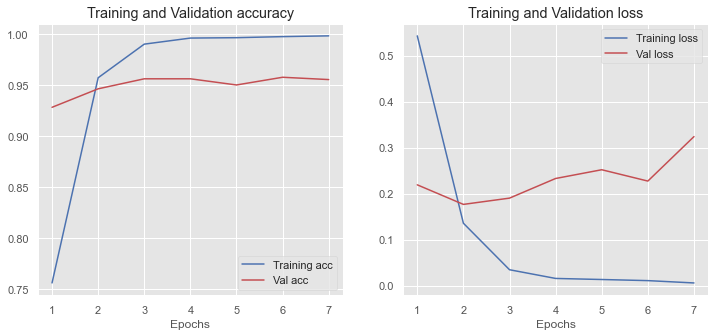

In [430]:
plot_history(history)

In [432]:
# Load model weights from epoch with best validation accuracy
model4.load_weights(output_dir+"/weights.06.hdf5")

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       442
           1       0.92      0.97      0.94       442
           2       0.98      0.96      0.97       441

    accuracy                           0.96      1325
   macro avg       0.96      0.96      0.96      1325
weighted avg       0.96      0.96      0.96      1325



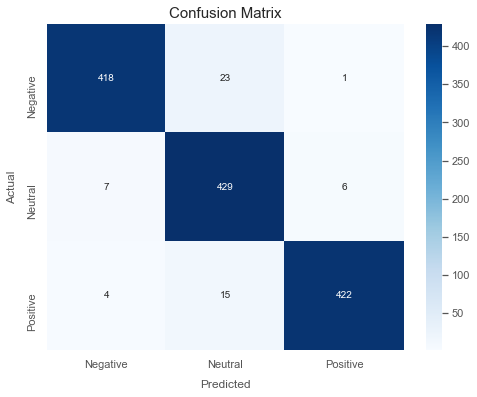

In [433]:
y_pred_prob = model4.predict(X_val_w)
y_pred_class = np.argmax(model4.predict(X_val_w), axis=-1)
y_val_integer = np.argmax(y_val_e, axis=1)
class_conf(y_val_integer,y_pred_class,labels)

In [434]:
results4 = metric_results(y_val_e,y_val_integer,y_pred_class,y_pred_prob)
results4

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.957736,0.958891,0.957735,0.957942,0.993621


In [435]:
model4.save("SentimentMultiNeural.h5")

##  Sentiment Model 5

In [436]:
# Dense model with 2 hidden dense layers and dropout on each
model5 = Sequential()
model5.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length=input_length))
model5.add(Flatten())
model5.add(Dense(512, activation='relu'))
model5.add(Dropout(rate=0.5))
model5.add(Dense(256, activation='relu'))
model5.add(Dropout(rate = 0.5))
model5.add(Dense(128,activation = 'relu'))
model5.add(Dense(3, activation='softmax')) 
model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model5.summary())

Model: "sequential_169"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_169 (Embedding)    (None, 20, 16)            96000     
_________________________________________________________________
flatten_169 (Flatten)        (None, 320)               0         
_________________________________________________________________
dense_495 (Dense)            (None, 512)               164352    
_________________________________________________________________
dropout_317 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_496 (Dense)            (None, 256)               131328    
_________________________________________________________________
dropout_318 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_497 (Dense)            (None, 128)            

In [437]:
# Set output directory and callbacks (patience set to 5)
output_dir = out('model_output/SentimentMultiClass5')
callbacks = call(output_dir,5)

In [438]:
# Model using keras embeddings
history = model5.fit(X_train_w,y_train_e,
                     epochs=epochs,
                     verbose=2,
                     callbacks = callbacks,
                     validation_data=(X_val_w, y_val_e),
                     batch_size=batch_size)

Epoch 1/50
1325/1325 - 1s - loss: 0.4806 - accuracy: 0.7945 - val_loss: 0.2167 - val_accuracy: 0.9260
Epoch 2/50
1325/1325 - 1s - loss: 0.1246 - accuracy: 0.9654 - val_loss: 0.1627 - val_accuracy: 0.9517
Epoch 3/50
1325/1325 - 1s - loss: 0.0335 - accuracy: 0.9911 - val_loss: 0.2103 - val_accuracy: 0.9502
Epoch 4/50
1325/1325 - 1s - loss: 0.0210 - accuracy: 0.9936 - val_loss: 0.2514 - val_accuracy: 0.9577
Epoch 5/50
1325/1325 - 1s - loss: 0.0073 - accuracy: 0.9983 - val_loss: 0.2408 - val_accuracy: 0.9525
Epoch 6/50
1325/1325 - 1s - loss: 0.0132 - accuracy: 0.9960 - val_loss: 0.2735 - val_accuracy: 0.9623
Epoch 7/50
1325/1325 - 1s - loss: 0.0128 - accuracy: 0.9967 - val_loss: 0.2754 - val_accuracy: 0.9600


In [439]:
# Print training and test accuracies
loss, accuracy = model5.evaluate(X_train_w, y_train_e, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model5.evaluate(X_val_w, y_val_e, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9989
Testing Accuracy:  0.9600


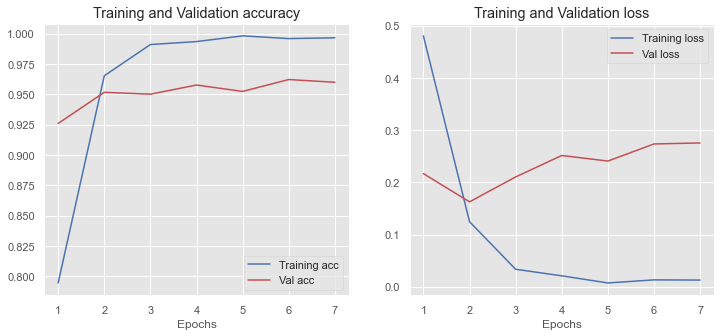

In [440]:
plot_history(history)

In [442]:
# Load model weights from epoch with best validation accuracy
model5.load_weights(output_dir+"/weights.06.hdf5")

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       442
           1       0.93      0.97      0.95       442
           2       0.99      0.96      0.97       441

    accuracy                           0.96      1325
   macro avg       0.96      0.96      0.96      1325
weighted avg       0.96      0.96      0.96      1325



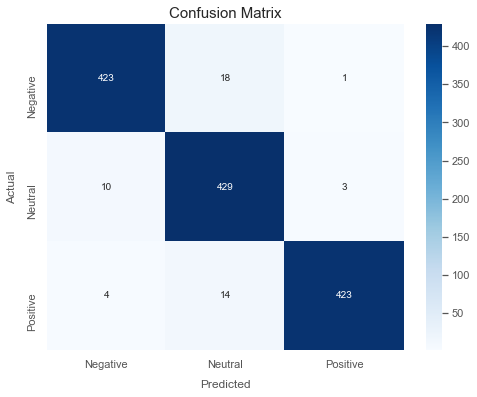

In [443]:
y_pred_prob = model5.predict(X_val_w)
y_pred_class = np.argmax(model5.predict(X_val_w), axis=-1)
y_val_integer = np.argmax(y_val_e, axis=1)
class_conf(y_val_integer,y_pred_class,labels)

In [444]:
results5 = metric_results(y_val_e,y_val_integer,y_pred_class,y_pred_prob)
results5

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.962264,0.96306,0.962262,0.962426,0.990328


In [445]:
model5.save("SentimentMultiNeuralb.h5")

# Section 4: Summary of results

In [446]:
models = ["Model1","Model2","Model3","Model4","Model5"]
summary_table = pd.concat([results1,results2,results3,results4,results5])
summary_table.set_index([models],inplace = True)
summary_table.to_csv("results_sentiment.csv")
summary_table.sort_values(by = "Accuracy",ascending = False)

,Accuracy,Precision,Recall,F1,ROCAUC
Model3,0.962264,0.963158,0.962264,0.962463,0.992342
Model5,0.962264,0.963060,0.962262,0.962426,0.990328
Model4,0.957736,0.958891,0.957735,0.957942,0.993621
Model2,0.956226,0.958020,0.956232,0.956467,0.992249
Model1,0.955472,0.957500,0.955469,0.955807,0.991916


# Section 5: Hyperparameter Tuning of the Best Model

In [447]:
# Dense model with 2 hidden dense layers and dropout on each
def network_model(learning_rate, initializer, dropout_rate, activation):
    model = Sequential()
    model.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length=input_length))
    model.add(Flatten())
    model.add(Dense(128,activation=activation,kernel_initializer=initializer ))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(3, activation='sigmoid')) 
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Use KerasClassifier to convert to sci-kit learn implementation to allow tuning to be easier
model = KerasClassifier(build_fn = network_model, verbose = 0)

In [448]:
learning_rate = [0.001, 0.01, 0.1]
initializer = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
batch_size = [8,16,32]
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
epochs = [10,20,50,100]
batch_size = [8,16,32]

param_distribs = {"learning_rate":learning_rate, "initializer":initializer,"batch_size":batch_size,
                  "dropout_rate" :dropout_rate, "activation":activation,"epochs" : epochs}
clf = RandomizedSearchCV(model, param_distribs, cv = 3,n_jobs = -1)
grid_result = clf.fit(X_train_w, y_train_e)

In [450]:
# Extract results from the gridsearch

# Set the scores
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

# Set the parameters
Act = [i['activation'] for i in params]
learning_rate = [i['learning_rate'] for i in params]
drop = [i['dropout_rate'] for i in params]
batch = [i['batch_size'] for i in params]
epoch = [i['epochs'] for i in params]
kern = [i['initializer'] for i in params]

# Show in dataframe and sort
cv_results = pd.DataFrame({'Mean Accuracy':means, 'Std':stds, 'Activation':Act, 'Learning Rate': learning_rate, 
                           'Batch size': batch, 'Epoch':epoch,'Kernel Init':kern,'Dropout': drop})
cv_results.sort_values(by=['Mean Accuracy'],ascending=False)

,Mean Accuracy,Std,Activation,Learning Rate,Batch size,Epoch,Kernel Init,Dropout
1,0.932522,0.007996,sigmoid,0.010,8,20,zero,0.7
0,0.931012,0.007779,relu,0.001,16,50,normal,0.2
9,0.926576,0.003744,relu,0.001,16,20,glorot_uniform,0.6
8,0.922612,0.006374,softplus,0.001,8,10,he_normal,0.1
7,0.507361,0.246020,linear,0.010,8,20,normal,0.0
2,0.333333,0.009251,softsign,0.100,16,50,he_uniform,0.7
3,0.333333,0.009251,relu,0.100,32,50,glorot_uniform,0.9
4,0.333333,0.009251,sigmoid,0.100,32,20,zero,0.9
5,0.333333,0.009251,relu,0.100,8,50,glorot_normal,0.6
6,0.327860,0.004410,softmax,0.100,8,100,uniform,0.5


No improvements in accuracy

# Section 6: Best Model against the Test Set

In [452]:
model4.load_weights('model_output/SentimentMulticlass4/weights.06.hdf5')

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       441
           1       0.94      0.97      0.95       441
           2       0.98      0.97      0.98       442

    accuracy                           0.96      1324
   macro avg       0.96      0.96      0.96      1324
weighted avg       0.96      0.96      0.96      1324



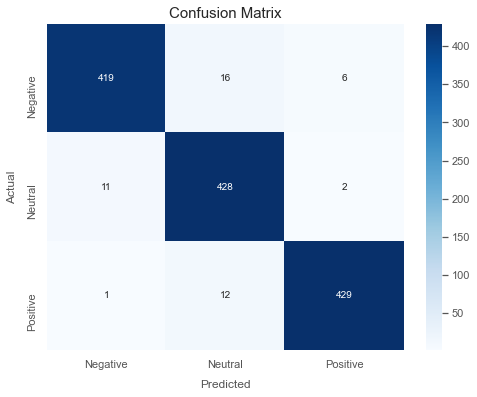

In [451]:
y_pred_prob = model4.predict(X_test_w)
y_pred_class = np.argmax(model4.predict(X_test_w), axis=-1)
y_test_integer = np.argmax(y_test_e, axis=1)
class_conf(y_test_integer,y_pred_class,labels)

In [454]:
results6= metric_results(y_test_e,y_test_integer,y_pred_class,y_pred_prob)
results6.index = ["Multi-class Sentiment NN Model 4"]
results6

,Accuracy,Precision,Recall,F1,ROCAUC
Multi-class Sentiment NN Model 4,0.963746,0.964149,0.963741,0.963803,0.989733
